In [2]:
!pip3 install torch torchvision
!pip install torchsummary
!pip install pyunpack
!pip install patool

    100% |████████████████████████████████| 591.8MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x6086e000 @  0x7f8b51dd62a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 18.6MB/s 
    100% |████████████████████████████████| 2.0MB 3.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.
  Running setup.py bdist_wheel for pyunpack ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/af/44/08/60613970881e542c0baad1f2dea5ed8e6716bc573f49197b7e
  Running setup.py bdist_wheel for easyprocess ... - \ | / done
  Stored in directory: /root/.cache

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchsummary import summary
from pyunpack import Archive
from torch.autograd import Variable
from logging import Logger
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sanchit2843","key":"60f3bf5b207ec03851f344c9a6984da9"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c cifar-10

  0% 0.00/3.04M [00:00<?, ?B/s]
100% 3.04M/3.04M [00:00<00:00, 101MB/s]
100% 609M/610M [00:06<00:00, 92.0MB/s]
100% 610M/610M [00:06<00:00, 99.7MB/s]
 90% 94.0M/105M [00:01<00:00, 44.3MB/s]
100% 105M/105M [00:01<00:00, 68.5MB/s] 
  0% 0.00/575k [00:00<?, ?B/s]
100% 575k/575k [00:00<00:00, 79.8MB/s]


In [0]:
Archive('train.7z').extractall('.')

In [0]:
import os
a = os.listdir('/content/train')

In [0]:
img_name = os.path.join('/content/train', a[0])

In [0]:
a[0]

In [0]:
import cv2
from torch.utils.data import Dataset, DataLoader
class DataLoader(Dataset):
  def __init__(self,a,root_dir):
    self.a = a
    self.root_dir = root_dir
  def __len__(self):
      return len(a)
  def __getitem__(self, idx):
      img_name = os.path.join(self.root_dir, a[idx])
      target = cv2.imread(img_name)
      input_img = cv2.imread(img_name,0)
      target = target/255
      return input_img,target

In [49]:
# input to output
class Generator_1(nn.Module):
  def __init__(self):
    super(Generator_1,self).__init__()
    self.conv1 = nn.Sequential(
                                nn.Conv2d(1,32,kernel_size = 4,stride = 2),
                                nn.BatchNorm2d(32),
                                nn.LeakyReLU(0.5)
                              )
    self.conv2 = nn.Sequential(
                                nn.Conv2d(32,64,kernel_size = 4,stride = 2),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(0.5)
                              )
    self.conv3 = nn.Sequential(
                                nn.Conv2d(64,128,kernel_size = 3,stride = 1),
                                nn.BatchNorm2d(128),
                                nn.LeakyReLU(0.5)
                              )
    #Deconvolution
    self.deconv1 = nn.Sequential(
                                nn.ConvTranspose2d(128,64,kernel_size = 3,stride = 1),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(0.5)
                              )
    self.deconv2 = nn.Sequential(
                                nn.ConvTranspose2d(64,32,kernel_size = 4,stride = 2),
                                nn.BatchNorm2d(32),
                                nn.LeakyReLU(0.5)
                              )
    self.deconv3 = nn.Sequential(
                                nn.ConvTranspose2d(32,3,kernel_size = 4,stride = 2),
                                nn.BatchNorm2d(3),
                                nn.LeakyReLU(0.5)
                              )
    self.deconv4 = nn.Sequential(
                                nn.ConvTranspose2d(3,3,kernel_size = 3,stride = 1),
                                nn.BatchNorm2d(3),
                              )
    
  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.deconv1(x)
    x = self.deconv2(x)
    x = self.deconv3(x)
    x = F.tanh(self.deconv4(x))
    return x
  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator_1().to(device)
summary(generator, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]             544
       BatchNorm2d-2           [-1, 32, 15, 15]              64
         LeakyReLU-3           [-1, 32, 15, 15]               0
            Conv2d-4             [-1, 64, 6, 6]          32,832
       BatchNorm2d-5             [-1, 64, 6, 6]             128
         LeakyReLU-6             [-1, 64, 6, 6]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
  ConvTranspose2d-10             [-1, 64, 6, 6]          73,792
      BatchNorm2d-11             [-1, 64, 6, 6]             128
        LeakyReLU-12             [-1, 64, 6, 6]               0
  ConvTranspose2d-13           [-1, 32, 14, 14]          32,800
      BatchNorm2d-14           [-1, 32,

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [0]:
root_dir = '/content/train'
dataset = DataLoader(a,root_dir)

In [0]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)

In [16]:
class Discriminator_1(nn.Module):
  def __init__(self):
    super(Discriminator_1,self).__init__()
    self.conv1 = nn.Sequential(
                                nn.Conv2d(3,32,kernel_size = 4,stride = 2),
                                nn.BatchNorm2d(32),
                                nn.LeakyReLU(0.5)
                              )
    self.conv2 = nn.Sequential(
                                nn.Conv2d(32,64,kernel_size = 4,stride = 2),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(0.5)
                              )
    self.conv3 = nn.Sequential(
                                nn.Conv2d(64,128,kernel_size = 3,stride = 1),
                                nn.BatchNorm2d(128),
                                nn.LeakyReLU(0.5)
                              )
    self.conv4 = nn.Sequential(
                                nn.Conv2d(128,256,kernel_size = 3,stride = 1),
                                nn.BatchNorm2d(256),
                                nn.LeakyReLU(0.5)
                              )
    self.fc1 = nn.Sequential( 
                                nn.Linear(1024, 512),
                                nn.LeakyReLU(0.2),
                                nn.Dropout(0.3)
                            )
    self.fc2 = nn.Sequential( 
                                nn.Linear(512, 128),
                                nn.LeakyReLU(0.2),
                                nn.Dropout(0.3)
                            )
    self.fc3 = nn.Sequential( 
                                nn.Linear(128, 1),                             
                            )
    
  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(-1,1024)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = F.sigmoid(x)
    return x
discriminator = Discriminator_1().to(device)
summary(discriminator, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]           1,568
       BatchNorm2d-2           [-1, 32, 15, 15]              64
         LeakyReLU-3           [-1, 32, 15, 15]               0
            Conv2d-4             [-1, 64, 6, 6]          32,832
       BatchNorm2d-5             [-1, 64, 6, 6]             128
         LeakyReLU-6             [-1, 64, 6, 6]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]         295,168
      BatchNorm2d-11            [-1, 256, 2, 2]             512
        LeakyReLU-12            [-1, 256, 2, 2]               0
           Linear-13                  [-1, 512]         524,800
        LeakyReLU-14                  [

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
import torch.optim as optim
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00001)
g_optimizer = optim.Adam(generator.parameters(), lr=0.001)
loss = nn.BCELoss()
loss1 = nn.MSELoss()

In [0]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    data = data.type(torch.cuda.FloatTensor)
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    data = data.type(torch.cuda.FloatTensor)
    return data

In [0]:
def train_discriminator(real,fake,optimizer):
  optimizer.zero_grad()
  N = real.size(0)
  #real_data
  prediction_real = discriminator(real)
  error_real = loss(prediction_real, zeros_target(N))
  error_real.backward()
  #fake_data
  prediction_fake = discriminator(fake)
  error_fake = loss(prediction_fake,ones_target(N))
  error_fake.backward()
  optimizer.step()
  return (error_real + error_fake)/2, prediction_real, prediction_fake

In [0]:
def train_generator(optimizer, fake , real_data):
    optimizer.zero_grad()
    #N = fake.size(0)
    # Sample noise and generate fake data
    #prediction = discriminator(fake_data)
    error = 1
    #error = loss(prediction, zeros_target(N))
    #error.backward(retain_graph=True)
    #optimizer.step()

    error2 = loss1(real_data,fake)
    error2.backward()
    optimizer.step()
    return error,error2

In [0]:
image,output = dataset[2]

In [51]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
from IPython.display import Image

for epoch in range(10):
  for n_batch,(input_img,output_img) in enumerate(dataloader):
        N = input_img.size(0)
        # 1. Train Discriminator
        input_img = input_img.view(N,1,32,32)
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        input_img = input_img.to(device)
        input_img = input_img.type(torch.cuda.FloatTensor)
        output_img = output_img.view(N,3,32,32)
        output_img = output_img.to(device)
        output_img = output_img.type(torch.cuda.FloatTensor)
        generator.train()
        fake_data = generator(input_img).detach()
        
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(output_img, fake_data,d_optimizer)
        # 2. Train Generator
        # Generate fake data
        fake_data = generator(input_img)
        # Train G
        g_error,reg_error = train_generator(g_optimizer, fake_data , output_img)
        if(n_batch%300==0):
          print('epochs : {}'.format(epoch) , 'd_error : {}'.format(d_error) , 'g_error : {}'.format(g_error) , 'reg_error : {}'.format(reg_error))
        # Display Progress every few batches
  torch.optim.lr_scheduler.StepLR(g_optimizer, 3, gamma=0.1, last_epoch=-1)
  generator.eval()
  image,_ = dataset[3]
  image = image.reshape((32,32,1))
  image = torch.from_numpy(image)
  image = image.type(torch.cuda.FloatTensor)
  image = image.view(1,1,32,32)
  target = generator(image).detach()
  b = target.to(torch.device("cpu"))
  b = b.numpy()
  b = np.reshape(b,(32,32,3))
  b = b*255
  cv2.imwrite('/content/generated/{}.png'.format(epoch),b)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epochs : 0 d_error : 6.071189880371094 g_error : 1 reg_error : 0.49418601393699646
epochs : 0 d_error : 0.027496974915266037 g_error : 1 reg_error : 0.11441733688116074
epochs : 0 d_error : 0.013999528251588345 g_error : 1 reg_error : 0.050934284925460815
epochs : 0 d_error : 0.04946921765804291 g_error : 1 reg_error : 0.04400559887290001
epochs : 0 d_error : 0.04256166145205498 g_error : 1 reg_error : 0.03485648334026337
epochs : 0 d_error : 0.0015248290728777647 g_error : 1 reg_error : 0.03384008631110191
epochs : 1 d_error : 0.002281107008457184 g_error : 1 reg_error : 0.035484880208969116
epochs : 1 d_error : 0.0032926532439887524 g_error : 1 reg_error : 0.03161979466676712
epochs : 1 d_error : 0.02046659216284752 g_error : 1 reg_error : 0.03108309581875801
epochs : 1 d_error : 0.055809617042541504 g_error : 1 reg_error : 0.03467024117708206
epochs : 1 d_error : 0.0015647540567442775 g_error : 1 reg_error : 0.03090626373887062
epochs : 1 d_error : 0.0025364644825458527 g_error : 1 

KeyboardInterrupt: ignored

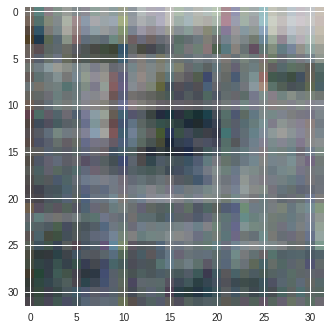

In [52]:
import cv2
c = cv2.imread('/content/generated/5.png')
plt.imshow(c)

In [0]:
!mkdir generated

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [0]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.sigmoid(x)